In [1]:
# Ver la posibilidad de darle peso a visitar nuevamente eventos y sobreescribirlos
# Encontrar la forma de visitar entre modelos sin la necesidad de que no se encuentre ninguno

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy import stats
from pandas import *
from sklearn import metrics

In [3]:
df_ccd1 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD1")).dropna()).round(5)
df_ccd2 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD2")).dropna()).round(5)
df_ccd3 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD3")).dropna()).round(5)
df_ccd4 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD4")).dropna()).round(5)
df_ccd5 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD5")).dropna()).round(5)
df_ccd6 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD6")).dropna()).round(5)
df_ccd7 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD7")).dropna()).round(5)
df_ccd8 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD8")).dropna()).round(5)
df_ccd9 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD9")).dropna()).round(5)
df_ccd10 = ((pd.read_csv("..//Prediction_Final/CCD_csv/CCD10")).dropna()).round(5)
df_ccd1.insert(0,"CCD",'1')
df_ccd2.insert(0,"CCD",'2')
df_ccd3.insert(0,"CCD",'3')
df_ccd4.insert(0,"CCD",'4')
df_ccd5.insert(0,"CCD",'5')
df_ccd6.insert(0,"CCD",'6')
df_ccd7.insert(0,"CCD",'7')
df_ccd8.insert(0,"CCD",'8')
df_ccd9.insert(0,"CCD",'9')
df_ccd10.insert(0,"CCD",'10')
df_all_ccd = [df_ccd1,df_ccd2,df_ccd3,df_ccd4,df_ccd5,df_ccd6,df_ccd7,df_ccd8,df_ccd9,df_ccd10]
df_ccd1_10 = (pd.concat(df_all_ccd)).reset_index(drop=True)
df_ccd1_10_test = df_ccd1_10.copy()
df_ccd1_10_test['eventNumber'] = 0
df_ccd1_10_test['CCD'] = df_ccd1_10_test['CCD'].astype(str).astype(int)

In [4]:
df_ccd1_10_test

,CCD,eventNumber,X_C,Y_C,X_size,Y_size,X_asymmetry,Y_asymmetry
0,1,0,15802.33461,14620.35174,118.47173,147.53655,14.09467,-24.15709
1,1,0,-12058.49296,-11492.29731,156.66280,173.41252,25.67475,29.28418
2,1,0,-1673.20612,10148.32818,144.31570,133.47211,0.60139,27.17641
3,1,0,9139.01511,-10861.48708,207.93866,205.27804,27.37437,27.03810
4,1,0,3988.38619,12383.93144,220.57626,388.06209,35.33761,-31.82236
...,...,...,...,...,...,...,...,...
8110,10,0,16366.02070,-8806.87093,134.62669,155.33595,-26.86031,-30.86280
8111,10,0,-27264.21988,-33962.84753,118.83261,116.90137,13.30867,16.52528
8112,10,0,23467.80676,-10399.54463,164.65480,179.49262,-28.08742,33.21410
8113,10,0,-25062.06878,-11399.35052,127.48449,210.26582,-25.32564,26.91978


# PREDICTION_V2

In [5]:
model = {
    'ccd_count': 10,
    'lr_asym_based' : {'slope': -15.083916850088121, 'intercept': -10.03846761488733},
    'lr_size_based' : {'slope':  7.669375140260721,  'intercept': -569.8930662208629},
    'asym_threshold': 30,   
    'size_threshold': 172,  
    'size_var':       50,       
    'error_range':    800,     
    'width_trace':    200,     
    'events_found':   0,
    'tracks_predict': {},
}

In [6]:
# Estima la posición del siguiente impacto y retorna los candidatos más cercanos
def first_prediction_(df, row, model,imprimir):
    CCD_step = 1
    flagSize = 0
    error    = model['error_range']
    size_var = model['size_var']
    #################################################################################
    # Probar si da mas aciertos el metodo de Oscar de buscar con ambos metodos en caso
    # de estar en el rango donde el modelo puede confundirse
    #################################################################################
    # Se activa un flag en caso de que se encuentre X_size o Y_size en el rango donde el modelo puede falllar
    if (model['size_threshold']-12)<row['X_size']<(model['size_threshold']+12) or (model['size_threshold']-12)<row['Y_size']<(model['size_threshold']+12):
        flagSize=1
    # Estima el desplazamiento en el eje x con el Modelo1 por lo que se aumenta el threshold
    if row['X_size'] < (model['size_threshold']+12):
        est_xi = row['X_asymmetry']*model['lr_asym_based']['slope'] + model['lr_asym_based']['intercept']
        row['est_x'] = est_xi
    else:
        est_xi = row['X_size']*model['lr_size_based']['slope'] + model['lr_size_based']['intercept']
        if row['X_asymmetry'] > 0: est_xi= -est_xi
        row['est_x'] = est_xi
            
    # Estima el desplazamiento en el eje y con el Modelo1 por lo que se aumenta el threshold
    if row['Y_size'] < (model['size_threshold']+12):
        est_yi = row['Y_asymmetry']*model['lr_asym_based']['slope'] + model['lr_asym_based']['intercept']
        row['est_y'] = est_yi
    else:
        est_yi = row['Y_size']*model['lr_size_based']['slope'] + model['lr_size_based']['intercept']
        if row['Y_asymmetry'] > 0: est_yi = -est_yi
        row['est_y'] = est_yi
    
    # Iteracion para realizar la busqueda con Modelo1
    while row['CCD']+CCD_step<=10:
        est_x = row['X_C'] + est_xi*(CCD_step) 
        est_y = row['Y_C'] + est_yi*(CCD_step)
        if imprimir: print('Busqueda MODELO 1')
        if imprimir: print('Estimaciones M1:', row['CCD']+CCD_step,'est_x: ',est_x,'est_y: ',est_y)
        
        if CCD_step == 1:
            prediction = df[ (df['CCD'] == row['CCD']+CCD_step) & (
                ((est_x - error) < df['X_C']) & (df['X_C'] < (est_x + error))) & (
                ((est_y - error) < df['Y_C']) & (df['Y_C'] < (est_y + error))) & (
                ((row['X_size'] - size_var) < df['X_size']) & (df['X_size'] < (row['X_size'] + size_var))) & (
                ((row['Y_size'] - size_var) < df['Y_size']) & (df['Y_size'] < (row['Y_size'] + size_var))   )]
            if imprimir: display(prediction)
        else:
            #print("point",row['CCD']+CCD_step)
            new_prediction =df[ (df['CCD'] == row['CCD']+CCD_step) & (
                ((est_x - error) < df['X_C']) & (df['X_C'] < (est_x + error))) & (
                ((est_y - error) < df['Y_C']) & (df['Y_C'] < (est_y + error))) & (
                ((row['X_size'] - size_var) < df['X_size']) & (df['X_size'] < (row['X_size'] + size_var))) & (
                ((row['Y_size'] - size_var) < df['Y_size']) & (df['Y_size'] < (row['Y_size'] + size_var))   )]
            prediction = pd.concat([prediction, new_prediction])
        CCD_step+=1
        
    # En el caso en el que al final de la busqueda no se encuentre ningun elemento, y en caso de estar activado el flagSize.
    # Se realiza una nueva busqueda pero usando el Modelo2 donde se disminuye el threshold.
    # Este es un caso especial para el cual se puede perder una busqueda debido a usar un modelo equivocado.
    
    #################################################################################
    
        if (row['CCD']+CCD_step==11)and(len(prediction.index)<5)and(flagSize==1):
            
            if imprimir: print('Busqueda MODELO 2')
        # Estima el desplazamiento en el eje x con el Modelo2 por lo que se disminuye el threshold
            if (model['size_threshold']-12) < row['X_size']: 
                est_xi = row['X_size']*model['lr_size_based']['slope'] + model['lr_size_based']['intercept']
                if row['X_asymmetry'] > 0: est_xi= -est_xi
                row['est_x'] = est_xi
            else:
                est_xi = row['X_asymmetry']*model['lr_asym_based']['slope'] + model['lr_asym_based']['intercept']  
                row['est_x'] = est_xi
         # Estima el desplazamiento en el eje y con el Modelo2 por lo que se disminuye el threshold
            if (model['size_threshold']-12) < row['Y_size']: 
                est_yi = row['Y_size']*model['lr_size_based']['slope'] + model['lr_size_based']['intercept']
                if row['Y_asymmetry'] > 0: est_yi = -est_yi
                row['est_y'] = est_yi
            else:
                est_yi = row['Y_asymmetry']*model['lr_asym_based']['slope'] + model['lr_asym_based']['intercept']
                row['est_y'] = est_yi
        # Iteracion para realizar la busqueda con el Modelo2
            CCD_step = 1
            while row['CCD']+CCD_step<=10:
                est_x = row['X_C'] + est_xi*(CCD_step) 
                est_y = row['Y_C'] + est_yi*(CCD_step)
                if imprimir: print('Estimaciones M2:', row['CCD']+CCD_step,'est_x: ',est_x,'est_y: ',est_y)
                if CCD_step == 1:
                    prediction = df[ (df['CCD'] == row['CCD']+CCD_step) & (
                        ((est_x - error) < df['X_C']) & (df['X_C'] < (est_x + error))) & (
                        ((est_y - error) < df['Y_C']) & (df['Y_C'] < (est_y + error))) & (
                        ((row['X_size'] - size_var) < df['X_size']) & (df['X_size'] < (row['X_size'] + size_var))) & (
                        ((row['Y_size'] - size_var) < df['Y_size']) & (df['Y_size'] < (row['Y_size'] + size_var))   )]
                    if imprimir: display(prediction)
                else:
                    new_prediction = df[ (df['CCD'] == row['CCD']+CCD_step) & (
                        ((est_x - error) < df['X_C']) & (df['X_C'] < (est_x + error))) & (
                        ((est_y - error) < df['Y_C']) & (df['Y_C'] < (est_y + error))) & (
                        ((row['X_size'] - size_var) < df['X_size']) & (df['X_size'] < (row['X_size'] + size_var))) & (
                        ((row['Y_size'] - size_var) < df['Y_size']) & (df['Y_size'] < (row['Y_size'] + size_var))   )]
                    prediction = pd.concat([prediction, new_prediction])
                CCD_step+=1
    #################################################################################
    # Se debiesen analizar aun los casos en los que aun a pesar de encontrarse busquedas y estar activado el flagSize.
    # Pudiese ser que esas busquedas sean equivocadas.
    #################################################################################
    
        try:    pred = prediction[prediction['eventNumber'] == 0]
        except: return
    #pred = prediction
    if len(pred.index) < 2: return pred
    centerX = row['X_C']
    centerY = row['Y_C']
    est_x   = row['est_x']
    est_y   = row['est_y']
    sizeX   = row['X_size']
    sizeY   = row['Y_size']
    asymX   = row['X_asymmetry']
    asymY   = row['Y_asymmetry']
    dist    = pred['CCD'].min()-row['CCD']
    #################################################################################
    # Nueva metrica que realiza la comparacion con la prediccion del centro y no con el centro buscado directamente.
    #    ----*--------------------(Centro Real)
    #    --------------*----------(Prediccion)
    #    ---------*-----*---------(Detecciones)
    # De modo que antes hacia match con la primera prediccion a pesar de que la segunda sea mas optima.
    # El problema es que esta realizando las comparaciones con su respectiva metrica.
    centerX_pred = centerX + dist*est_x
    centerY_pred = centerY + dist*est_y    
    # Esta metrica de momento da mas peso en los CCD de menor numero y en aquellos iguales hay cierta 
    # proporcionales entre cada asignacion
    pred = pred.assign( center_diff =  (pred['CCD'])*( np.sqrt((pred['X_C'] - centerX_pred)**2 +  (pred['Y_C'] - centerY_pred) **2 )) )
    pred = pred.assign( size_diff   =  (pred['CCD'])*( np.sqrt((pred['X_size'] - sizeX)**2 + (pred['Y_size'] - sizeY)**2 ))) 
    pred = pred.assign( asym_diff   =  (pred['CCD'])*( np.sqrt((pred['X_asymmetry'] - asymX)**2 + (pred['Y_asymmetry'] - asymY)**2 )))
    #################################################################################
    # Filtros de prediccion que deben analizarse mas a profundidad pero funcionan bajo la logica
    # de aplicar un castigo a aquellos valores que esten fuera del rango
    pred.loc[abs(pred['X_size']-sizeX)>50,'size_diff'] = 100000*dist
    pred.loc[abs(pred['Y_size']-sizeY)>50,'size_diff'] = 100000*dist
    pred.loc[abs(pred['X_asymmetry']-asymX)>30,'asym_diff'] = 100000*dist
    pred.loc[abs(pred['Y_asymmetry']-asymY)>30,'asym_diff'] = 100000*dist
    
    pred = pred.assign(sort_metric = pred['size_diff'] + pred['center_diff'] + pred['asym_diff'] )
    # Selecciona el candidato con menor diferencia
    final_pred = pred.sort_values('sort_metric').drop(['size_diff','center_diff','sort_metric','asym_diff'], axis=1).iloc[[0]]
    if imprimir:
        print("Metricas de comparacion")
        display(pred)
        print("Primera prediccion Final")
        display(final_pred)
    return final_pred

In [7]:
def follow_predictionCCD(df,row,model,est_x,est_y,const):
    error    = model['width_trace']
    asym     = model['asym_threshold']
    prediction = df[ (df['CCD'] == row['CCD']+const) & (
            ((est_x - error) < df['X_C']) & (df['X_C'] < (est_x + error))) & (
            ((est_y - error) < df['Y_C']) & (df['Y_C'] < (est_y + error))) & ( (
            ((row['X_asymmetry'] - asym) < df['X_asymmetry']) & (df['X_asymmetry'] < (row['X_asymmetry'] + asym)) ) ) & (
            ((row['Y_asymmetry'] - asym) < df['Y_asymmetry']) & (df['Y_asymmetry'] < (row['Y_asymmetry'] + asym))) ]
    return prediction

def trace_path_(df, point_a, point_b, model,imprimir):
    CCD_step = 1 
    CCD_distance = point_b['CCD'] - point_a['CCD']
    error    = model['error_range']
    size_var = model['size_var']
    sizeX = point_b['X_size']
    sizeY = point_b['Y_size'] 
   
    while point_b['CCD'] + CCD_step <= 10:        
        est_x = point_b['X_C'] + (point_b['X_C'] - point_a['X_C'])*(CCD_step/CCD_distance)
        est_y = point_b['Y_C'] + (point_b['Y_C'] - point_a['Y_C'])*(CCD_step/CCD_distance)
        if CCD_step == 1: prediction = follow_predictionCCD(df,point_b,model,est_x,est_y,CCD_step)
        else: 
            new_prediction = follow_predictionCCD(df,point_b,model,est_x,est_y,CCD_step)
            prediction = pd.concat([prediction, new_prediction])
        CCD_step += 1
        
    prediction = prediction[prediction['eventNumber'] == 0]
    return prediction

# Busca el siguiente impacto de un track
def follow_path_(df, point_a, point_b, model, path,imprimir):
    if point_b['CCD'] == model['ccd_count']:
        model['events_found'] += 1
        df.loc[path, 'eventNumber'] = model['events_found']
        return
    pred = trace_path_(df, point_a, point_b, model,imprimir)
    if imprimir:
        print("Posibles impactos trace_path")
        display(pred)
    pred = best_follow_(point_b, pred, model)
    if imprimir:
        print("Mejor impacto best_follow")
        display(pred)
    if pred.shape[0] == 0:
        model['events_found'] += 1
        df.loc[path, 'eventNumber'] = model['events_found']
        return
    path.append(pred.index[0])
    #######################################################
    pred = pred.assign( est_x = point_b['est_x'] )
    pred = pred.assign( est_y = point_b['est_y'] )
    #######################################################
    follow_path_(df, point_b, pred.squeeze(), model, path,imprimir)

In [8]:
def best_follow_(row, pred, model):
    if len(pred.index) < 2: return pred
    
    centerX = row['X_C']
    centerY = row['Y_C']
    sizeX = row['X_size']
    sizeY = row['Y_size']
    asymX = row['X_asymmetry']
    asymY = row['Y_asymmetry']
    dist = pred['CCD'].min() - row['CCD']
    est_x   = row['est_x']
    est_y   = row['est_y']
    #######################################################
    centerX_pred = centerX + dist*est_x
    centerY_pred = centerY + dist*est_y
    pred = pred.assign( center_diff =  (pred['CCD'])*( np.sqrt((pred['X_C'] - centerX_pred)**2 +  (pred['Y_C'] - centerY_pred) **2 )) )    
    pred = pred.assign( size_diff   =  (pred['CCD'])*( np.sqrt((pred['X_size'] - sizeX)**2 + (pred['Y_size'] - sizeY)**2 ) ))
    pred = pred.assign( asym_diff   =  (pred['CCD'])*( np.sqrt((pred['X_asymmetry'] - asymX)**2 + (pred['Y_asymmetry'] - asymY)**2 ))) 
    #######################################################
    pred.loc[abs(pred['X_size']-sizeX)>50,'size_diff'] = 100000*dist
    pred.loc[abs(pred['Y_size']-sizeY)>50,'size_diff'] = 100000*dist
    pred.loc[abs(pred['X_asymmetry']-asymX)>30,'asym_diff'] = 100000*dist
    pred.loc[abs(pred['Y_asymmetry']-asymY)>30,'asym_diff'] = 100000*dist

    pred = pred.assign(sort_metric = pred['size_diff'] + pred['center_diff'] + pred['asym_diff'] )
    
    final_pred = pred.sort_values('sort_metric').drop(['center_diff','size_diff','sort_metric','asym_diff'], axis=1).iloc[[0]]
    if imprimir:
        print("Metricas de comparacion")
        display(pred)
        print("Primera prediccion Final")
        display(final_pred)
    return final_pred

In [ ]:
model['events_found'] = 0
imprimir = False
for i in range(len(df_ccd1_10_test)):
    row = df_ccd1_10_test.iloc[i].copy()
    if i==928: imprimir = True 
    else: imprimir = False
        
    if imprimir:
        print("Nuevo evento")
        display (row)   
        
    #Detecta las filas con ccd 10 y si no estan asignadas a un evento, agregan un evento
    if row['CCD'] == 10 and row['eventNumber'] == 0:
        model['events_found'] += 1
        df_ccd1_10_test.loc[i, 'eventNumber'] = model['events_found']
        continue  
        
    # Si el impacto ya fue visitado avanza al siguiente
    if row['eventNumber'] != 0: continue
        
    # Determina cuales pueden ser los impactos siguientes y selecciona el más similar
    pred = first_prediction_(df_ccd1_10_test, row, model,imprimir)
    
    if imprimir: 
        print('La mejor primera prediccion: ')
        display(pred)
    
    # Si no se encontró ningún impacto en el área de búsqueda
    if pred.shape[0] == 0:
        model['events_found'] += 1
        df_ccd1_10_test.loc[i, 'eventNumber'] = model['events_found']
        continue
    #######################################################   
    # Se agrega una columna a la prediccion que represente la diferencia entre la prediccion y el valor original
    pred = pred.assign(est_x = (pred['X_C']-row['X_C'])/(pred['CCD']-row['CCD']) )
    pred = pred.assign(est_y = (pred['Y_C']-row['Y_C'])/(pred['CCD']-row['CCD']) )
    # Aun se debe analizar el caso en el que la prediccion sea vacia 
    #######################################################
    # Agrega los impactos hallados al track
    path = [i, pred.index[0]]
    follow_path_(df_ccd1_10_test, row, pred.squeeze(), model, path,imprimir)
    #if i==460: break

In [ ]:
#Caso Actual: 929 al eliminar en la busqueda el size_var encuentra, NO TIENE LOGICA.
#             1503 el caso imposible
#             [456, 469, 1512]
# Porque eliminando x_size funciona? no se
#             eventNumber=3 me roba un evento de 10 impactos debido a encontrar mal el segundo 
#             -> Solucionado: Nueva Metrica (Funcional pero no mejora demasiado)

# Eventos casi imposibles


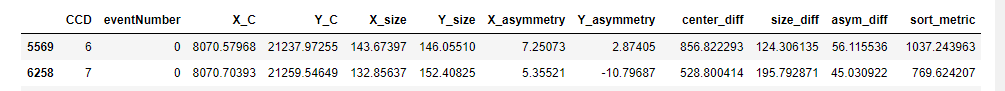
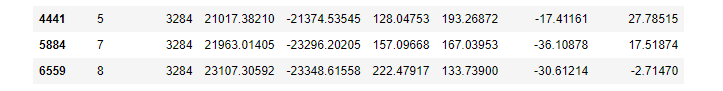

# BREAK

In [ ]:
df_ccd1_10_predic = df_ccd1_10_test
num_events = df_ccd1_10 ['eventNumber'].nunique()
unique_values = df_ccd1_10 ['eventNumber'].unique().tolist()
df_ccd1_3_sort = df_ccd1_10.sort_values('eventNumber')

hit = [0] * 10
miss = [0] * 10
contador = 0
events_fails=[]
for event in unique_values:
    df = (df_ccd1_10[df_ccd1_10['eventNumber'] == event]).copy()
    x_c , ccd = df.iloc[0]['X_C'] , df.iloc[0]['CCD']   
    eventNumber_predict  = int((df_ccd1_10_predic[df_ccd1_10_predic['X_C'] == x_c]).iloc[0]['eventNumber'])
    df_predic = (df_ccd1_10_predic[df_ccd1_10_predic['eventNumber'] == int(eventNumber_predict)]).copy()
    
    df = df.drop('eventNumber', axis=1)
    df.reset_index(inplace=True)
    df_predic = df_predic.drop('eventNumber', axis=1)
    df_predic.reset_index(inplace=True)
    df['CCD'] = df['CCD'].astype(int)
    cant_ccd = df.shape[0]
    if df.shape[0] == df_predic.shape[0]: 
        diferencias = df_predic.compare(df)
        if diferencias.empty: ##Perfect tracking
            hit[cant_ccd-1]+=1
        else:
            miss[cant_ccd-1]+=1
            contador+=1
            events_fails.append(event)
    else:
        miss[cant_ccd-1]+=1
        contador+=1
        events_fails.append(event)

#Para medir la precision
misses_total=0
for i in range(10):
    real    = hit[i]+miss[i]
    predict = hit[i]
    precision = (predict/real)
    misses    = real - predict
    misses_total+=misses
    print("CCD:",i+1,"Real: ",real, "Prediction: ",predict,"Precision: ",precision,"Misses: ",misses)
print("Precision general ",100*sum(hit)/(sum(hit)+sum(miss)))
print("Valores perdidos totales: ",misses_total)
#Eliminando sizeX: Valores perdidos totales:  75 (71 si es solo en la segunda pred)
#Eliminando sizeY: Valores perdidos totales:  80
#Eliminando 1.eventnumber=0: 75, 2.eventnumber=0: 69, 2.1.eventnumber=0: 82
#Consideracion interesante: Eliminar el segundo eventNumber=0 deja la misma cantidad de eventos perdidos.

In [47]:
diff_track_1=[];diff_track_2=[];diff_track_3=[];diff_track_4=[];diff_track_5=[]
diff_track_6=[];diff_track_7=[];diff_track_8=[];diff_track_9=[]

stop = df_ccd1_10_test['eventNumber'].max()
for i in range(stop):
    t1=len(df_ccd1_10_test.loc[df_ccd1_10_predic['eventNumber'] ==(i+1)])
    t2=len(df_ccd1_10.loc[df_ccd1_10['eventNumber'] == df_ccd1_10.loc[df_ccd1_10_predic[df_ccd1_10_predic['eventNumber']==(i+1)].index[0]]['eventNumber']])
    if t1!=t2:
        if abs(t1-t2)==1: diff_track_1.append(i+1) #56
        if abs(t1-t2)==2: diff_track_2.append(i+1) #15
        if abs(t1-t2)==3: diff_track_3.append(i+1) #7
        if abs(t1-t2)==4: diff_track_4.append(i+1) #8
        if abs(t1-t2)==5: diff_track_5.append(i+1) #6
        if abs(t1-t2)==6: diff_track_6.append(i+1) #4
        if abs(t1-t2)==7: diff_track_7.append(i+1) #1
        if abs(t1-t2)==8: diff_track_8.append(i+1) #2
        if abs(t1-t2)==9: diff_track_9.append(i+1) #0
        #Total: 99

In [48]:
diff_track_2

[307,
 316,
 342,
 835,
 1075,
 1121,
 1140,
 1483,
 1487,
 1490,
 1492,
 1493,
 1497,
 1505,
 1511]

In [60]:
df_ccd1_10_test[df_ccd1_10_test['eventNumber']==1502]

,CCD,eventNumber,X_C,Y_C,X_size,Y_size,X_asymmetry,Y_asymmetry
5504,6,1502,21062.95842,-31275.34904,173.39455,190.26246,-38.63317,27.75583
7454,9,1502,22855.14858,-33893.38836,140.81415,186.13729,-24.89696,28.77618


In [50]:
df_ccd1_10.loc[df_ccd1_10['eventNumber'] == df_ccd1_10.loc[df_ccd1_10_test[df_ccd1_10_test['eventNumber']==1121].index[0]]['eventNumber']]

,CCD,eventNumber,X_C,Y_C,X_size,Y_size,X_asymmetry,Y_asymmetry
1120,1,7725,17702.88654,-26224.36555,159.15866,210.51354,-23.98014,29.19604
2205,2,7725,18415.17406,-27329.02224,163.39722,222.07634,-25.31462,36.98645
3106,3,7725,19078.05435,-28396.92182,173.67451,199.19833,-33.37479,27.77954
3985,4,7725,19822.52505,-29363.27609,159.65754,204.79817,-23.72596,32.94898
5504,6,7725,21062.95842,-31275.34904,173.39455,190.26246,-38.63317,27.75583
7454,9,7725,22855.14858,-33893.38836,140.81415,186.13729,-24.89696,28.77618


In [59]:
df_ccd1_10_test.loc[5504]

CCD                6.00000
eventNumber     1502.00000
X_C            21062.95842
Y_C           -31275.34904
X_size           173.39455
Y_size           190.26246
X_asymmetry      -38.63317
Y_asymmetry       27.75583
Name: 5504, dtype: float64

# Algoritmo de comparacion 

In [84]:
df_ccd1_10.head()
num_events = df_ccd1_10 ['eventNumber'].nunique()
unique_values = df_ccd1_10 ['eventNumber'].unique().tolist()
df_ccd1_20_sort = df_ccd1_10.sort_values('eventNumber')

In [88]:
def show_events (df1,df2,event_number):
    df = (df1[df1['eventNumber'] == event_number]).copy()
    x_c , ccd = df.iloc[0]['X_C'] , df.iloc[0]['CCD']
    eventNumber_predict  = int((df2[df2['X_C'] == x_c]).iloc[0]['eventNumber'])
    df_predic = (df2[df2['eventNumber'] == int(eventNumber_predict)]).copy()
    return df, df_predic

In [95]:
show_events(df_ccd1_10,df_ccd1_10_test,3527)

(     CCD  eventNumber          X_C          Y_C     X_size     Y_size   
 508    1         3527 -16147.94138   3880.46765  171.74885  266.49946  \
 2739   3         3527 -14568.66891   6874.84347  169.41935  263.08372   
 3632   4         3527 -13787.41543   8377.67088  166.11780  260.69428   
 4455   5         3527 -13013.72684   9872.38623  169.05994  263.65945   
 5206   6         3527 -12247.14426  11376.92895  165.59580  259.17830   
 5896   7         3527 -11483.13635  12877.77481  172.55596  260.38936   
 6570   8         3527 -10703.67411  14385.66449  179.27460  265.83801   
 7194   9         3527  -9921.02768  15900.73109  178.23533  261.56255   
 7776  10         3527  -9141.73586  17419.85653  180.43295  261.42617   
 
       X_asymmetry  Y_asymmetry  
 508     -27.26621    -29.12724  
 2739    -27.93343    -29.52820  
 3632    -24.91483    -25.83430  
 4455    -26.21143    -27.24343  
 5206    -25.23747    -26.58217  
 5896    -30.84029    -27.66755  
 6570    -33.04009  

# Determinar valores de rango

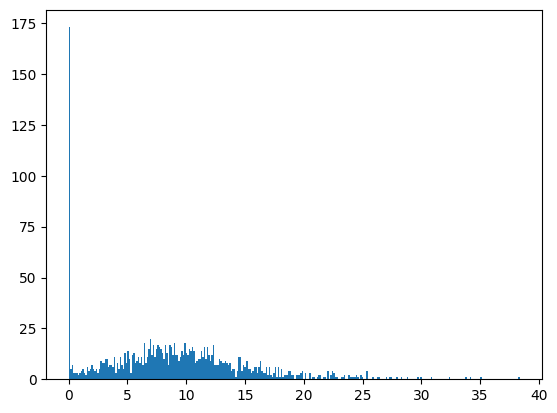

In [24]:
sizex_diff=[]
sizey_diff=[]
for event in unique_values:
    df = (df_ccd1_10[df_ccd1_10['eventNumber'] == event]).copy()
    sizex_diff.append(df['X_asymmetry'].max()-df['X_asymmetry'].min())
    sizey_diff.append(df['Y_size'].max()-df['Y_size'].min())
    
hist1 = plt.hist(sizex_diff, bins=300)

plt.show()

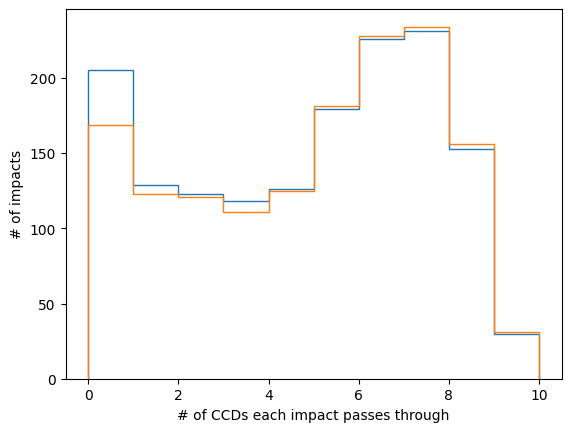

In [43]:
ccd_count_predic = pd.DataFrame({'count': df_ccd1_10_test['eventNumber'].value_counts().sort_index()})
ccd_count= pd.DataFrame({'count': df_ccd1_10['eventNumber'].value_counts().sort_index()})

ccd_count_predic.index.name = 'eventNumber'
ccd_count.index.name = 'eventNumber'

freq_predic = ccd_count_predic.value_counts().sort_index()
freq = ccd_count.value_counts().sort_index()
plt.stairs(np.round(freq_predic))
plt.stairs(np.round(freq))
plt.xlabel("# of CCDs each impact passes through")
plt.ylabel("# of impacts")
plt.show()

In [14]:
display(abs(freq_predic)) 

NameError: name 'freq_predic' is not defined